<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select your Dataset

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Shape Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 0

# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
# 0 = airplane
# 1 = automobile
# 2 = bird
# 3 = cat
# 4 = deer										
# 5 = dog
# 6 = frog
# 7 = horse
# 8 = ship
# 9 = truck
CIFAR10_CLASS = 0

# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "dog"

# Choose Whether to Train or Load a Model

In [0]:
# True = Load and output results for a model trained on the chosen dataset
# False = Train on the chosen dataset and output results 
LOAD_MODEL = True

# Provide the filename of the model to load/save
# Leave as None to use the default filename which will be named after the dataset
MODEL_NAME = None

# If LOAD_MODEL = False, choose whether to save the model
# True = Train and save
# False = Train only
SAVE_MODEL = True

# Define Training Hyper-Parameters

In [0]:
BATCH_SIZE = 512
LEARNING_RATE = 0.001
TRAINING_EPOCHS = 10000

# Library Imports

In [24]:
# TODO: Test which of these imports are needed

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import models, backend, utils, optimizers, regularizers
from tensorflow.keras.layers import Input, Conv2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Dataset Setup

unzip:  cannot find or open /content/gdrive/My Drive/Dissertation/Data/ShapeSet/ShapeSet.zip, /content/gdrive/My Drive/Dissertation/Data/ShapeSet/ShapeSet.zip.zip or /content/gdrive/My Drive/Dissertation/Data/ShapeSet/ShapeSet.zip.ZIP.


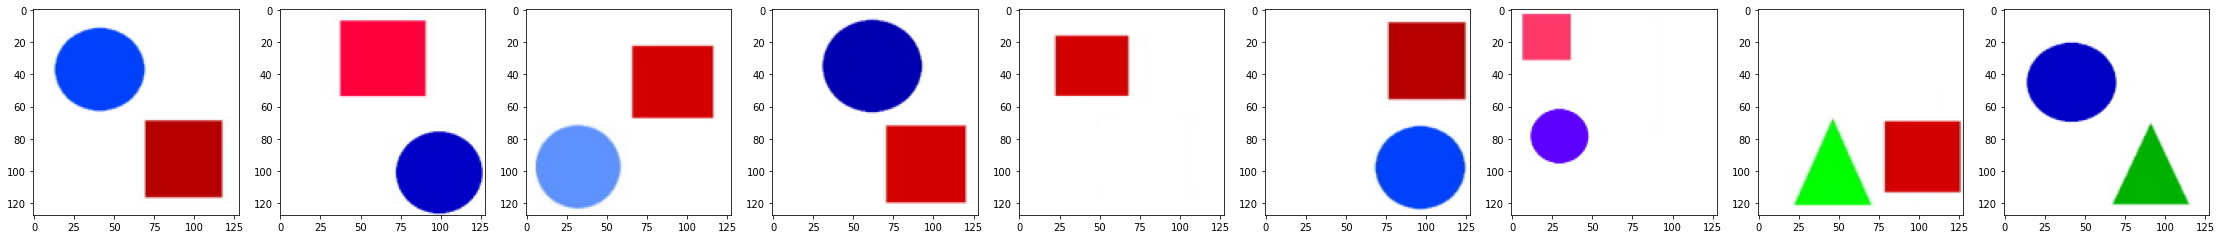

In [25]:
if(DATASET_CHOICE == 0):
  BATCH_SIZE = 10
  
  !unzip -uq "/content/gdrive/My Drive/Dissertation/Data/ShapeSet/ShapeSet.zip" -d "/content/gdrive/My Drive/Dissertation/Data/ShapeSet/" 
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/ShapeSet"

  images = []
  for image in io.imread_collection(base_dir + "/*.jpg"): 
    if(image.shape == (128, 128, 3)):
      images.append(np.array(image))
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  images = np.array(images)[indices]
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  train_images = train_images / 255.0
  test_images = test_images / 255.0

  output_count = 9
  index_offset = 0

  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(images[i])

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

  if(MODEL_NAME is None):
    MODEL_NAME = "ShapeSet"

elif(DATASET_CHOICE == 1):
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]

  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  output_count = 12
  index_offset = 20

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  if(MODEL_NAME is None):
    if(CIFAR10_CLASS is not None):
      MODEL_NAME = "Cifar10-" + CIFAR10_CLASS
    else:
      MODEL_NAME = "Cifar10"

elif(DATASET_CHOICE == 2):
  !git clone https://github.com/2014mchidamb/DeepColorization/

  images = train_images = test_images = []
  for image in io.imread_collection('DeepColorization/face_images/*.jpg'): 
    images.append(resize(image, (128, 128)))
    
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  index_offset = 20
  output_count = 12
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  if(MODEL_NAME is None):
    MODEL_NAME = "Faces"

elif(DATASET_CHOICE == 3):
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/imagenette2-160/"

  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection(base_dir + "train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection(base_dir + "val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  index_offset = 0
  output_count = 12

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  if(MODEL_NAME is None):
    MODEL_NAME = "Imagenette-" + categories[IMAGENETTE_CATEGORY]

# Create the Colourisation CNN

In [26]:
y_input = Input(shape=(train_uv.shape[1], train_uv.shape[2], 1))
layer = Conv2D(8, (3, 3), activation='relu')(y_input)
layer = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = Dropout(0.2)(layer)
layer = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = Dropout(0.2)(layer)
layer = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
layer = Dropout(0.2)(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
layer = Dropout(0.2)(layer)
layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2, 2))(layer)
uv_out = Conv2D(2, (3, 3), activation='tanh', padding='same')(layer)

dcnn = Model(y_input, uv_out, name='dcnn')
opt = optimizers.Adam(lr=LEARNING_RATE)
dcnn.compile(optimizer=opt, loss='mse')
dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 126, 126, 8)       80        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 63, 63, 32)        2336      
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       73856  


# Train/Load the Colourisation Model

In [27]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=60)
train_iterator = datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE)
model_dir = "/content/gdrive/My Drive/Dissertation/Models/DCNN/"

# TODO: DOUBLE CHECK WHAT THESE MODEL DIRECTORIES WILL BE WHEN SOMEONE ELSE RUNS THE NOTEBOOK
if(LOAD_MODEL):
  json_file = open(model_dir + MODEL_NAME + ".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  dcnn = models.model_from_json(loaded_model_json)

  dcnn.load_weights(model_dir + MODEL_NAME + ".h5", by_name=False)

  dcnn.compile(optimizer=opt, loss='mse')

  total_loss = np.loadtxt(model_dir + MODEL_NAME + "-loss.csv", delimiter=',')
  total_val_loss = np.loadtxt(model_dir + MODEL_NAME + "-val_loss.csv", delimiter=',')

  print("Loaded model from disk")

else:
  history = dcnn.fit(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=TRAINING_EPOCHS, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)

  total_loss = history.history["loss"]
  total_val_loss = history.history["val_loss"]

  if(SAVE_MODEL):
    model_json = dcnn.to_json()
    with open(model_dir + MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)

    dcnn.save_weights(model_dir + MODEL_NAME + ".h5")

    np.savetxt(model_dir + MODEL_NAME + "-loss.csv", total_loss, delimiter=',')
    np.savetxt(model_dir + MODEL_NAME + "-val_loss.csv", total_val_loss, delimiter=',')

    print("Saved model to disk")

Loaded model from disk


# Colourisation Diagnostic Learning Curves

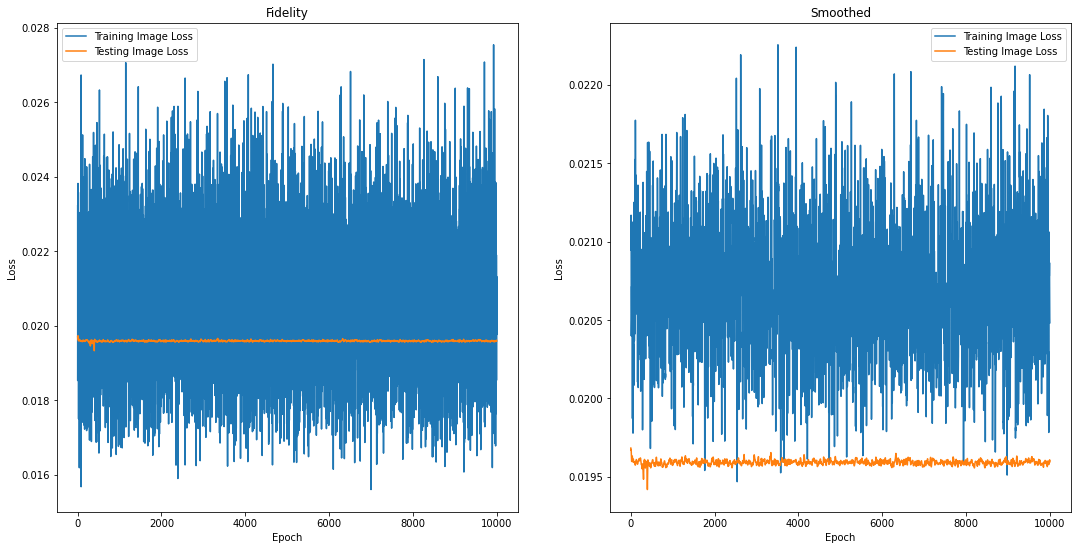

In [28]:
fig = plt.figure(figsize=(38, 9))

ax = fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(total_loss, label="Training Image Loss")
plt.plot(total_val_loss, label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ax = fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_loss, sigma=2), label="Training Image Loss")
plt.plot(gaussian_filter1d(total_val_loss, sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training Results

3/3 [==============================] - 0s 3ms/step - loss: 0.0232
0.023182841017842293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


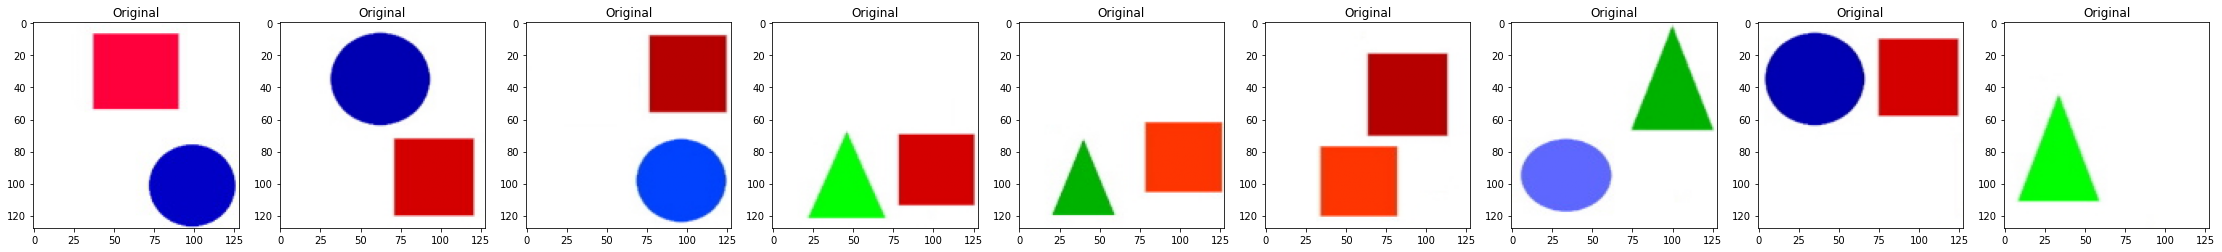

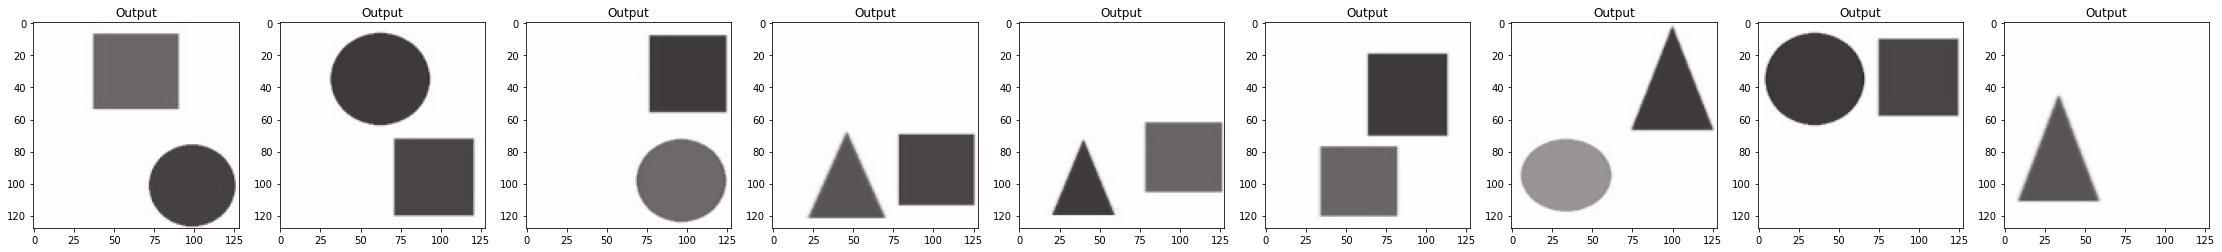

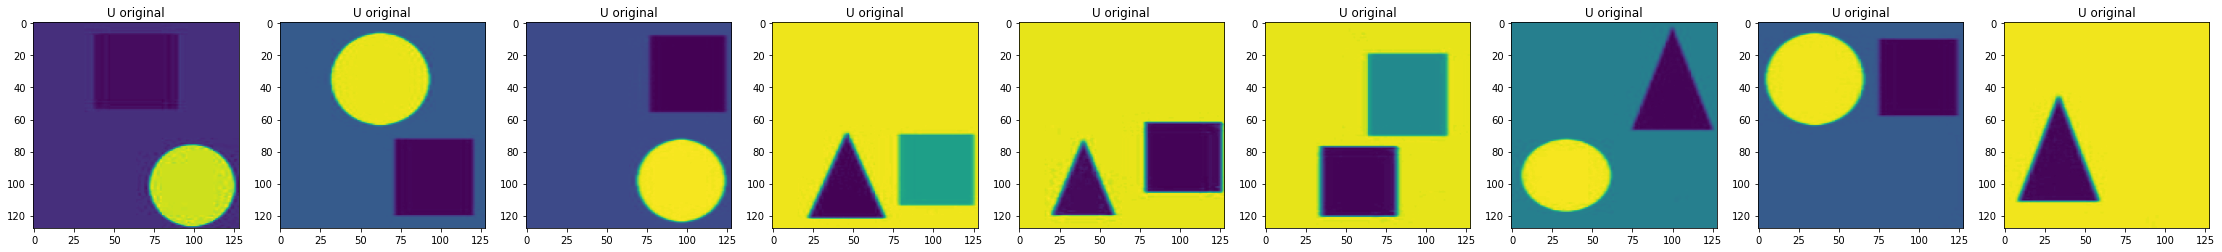

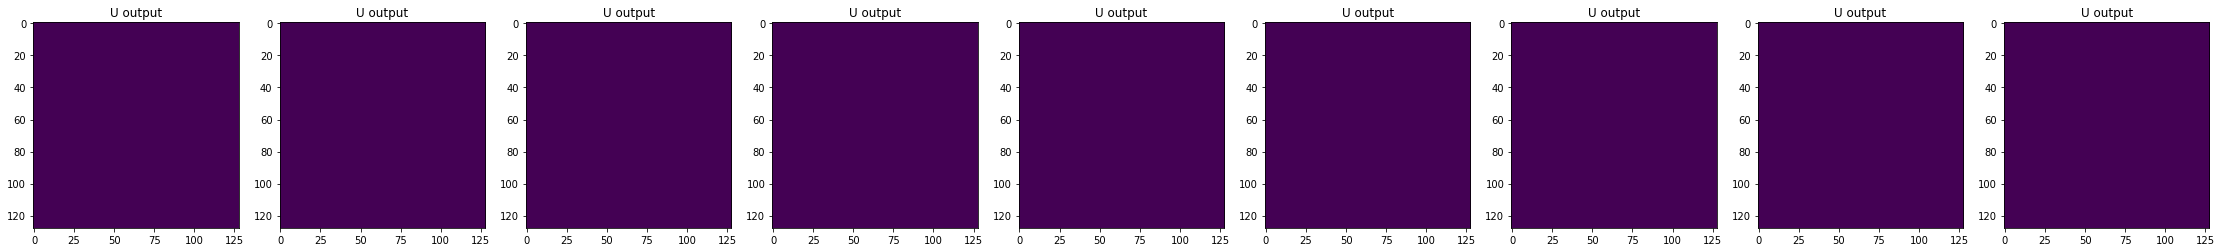

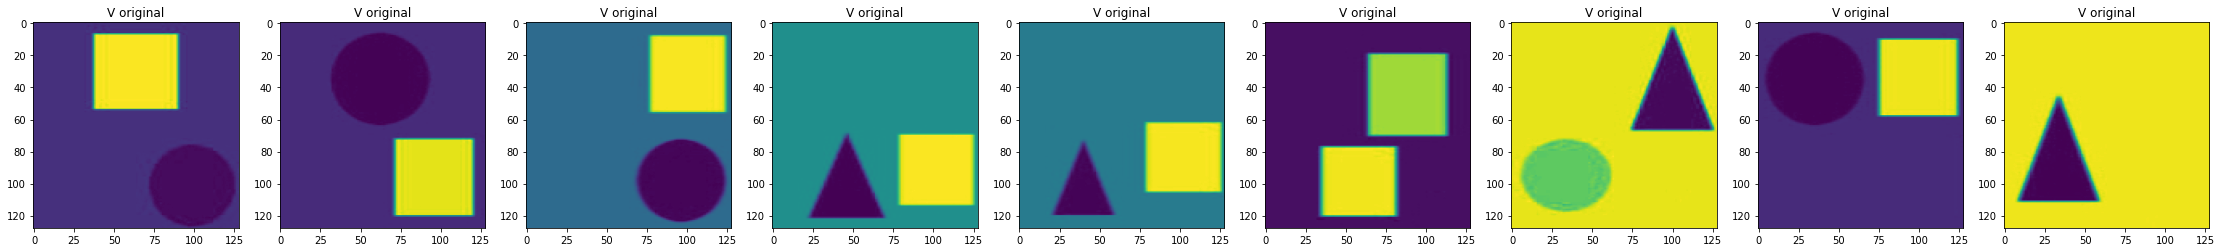

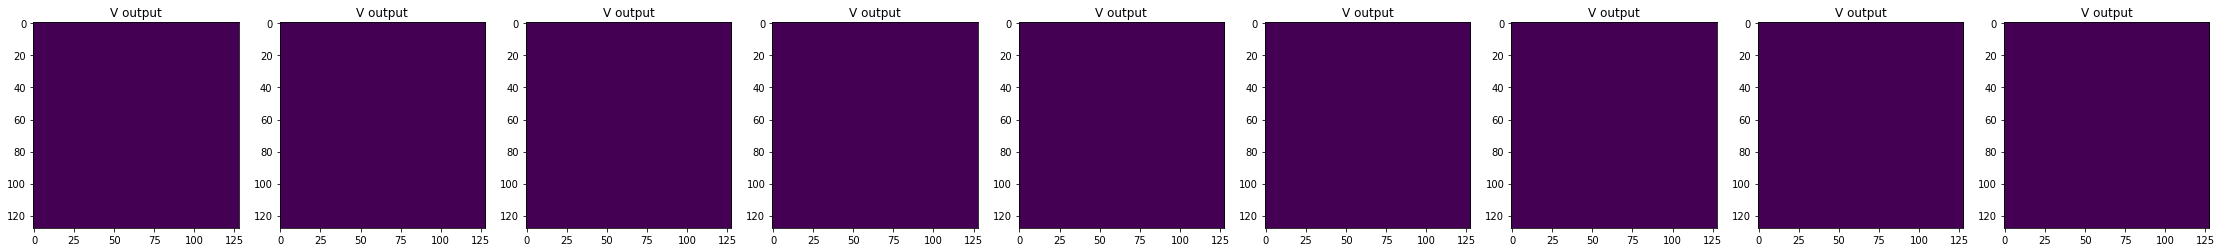

In [29]:
print(dcnn.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = dcnn.predict(train_y)
result = np.zeros((train_y.shape[0], train_y.shape[1], train_y.shape[2], 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

# Testing Results

3/3 [==============================] - 0s 3ms/step - loss: 0.0180
0.018045863136649132


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


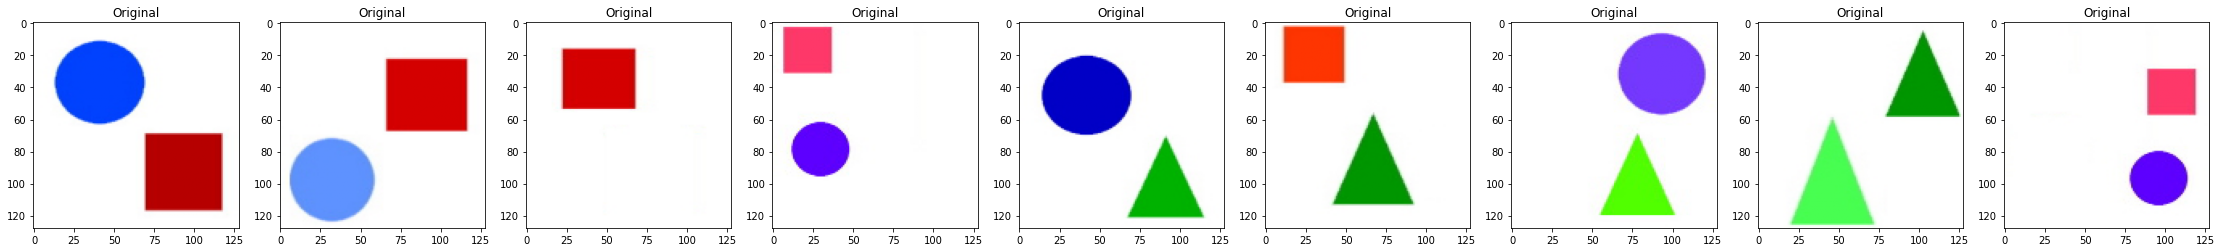

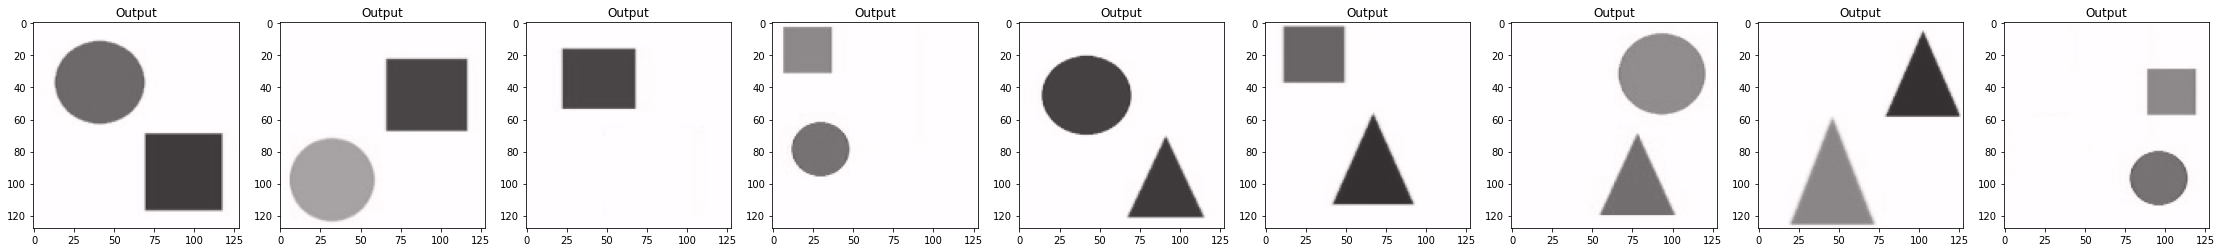

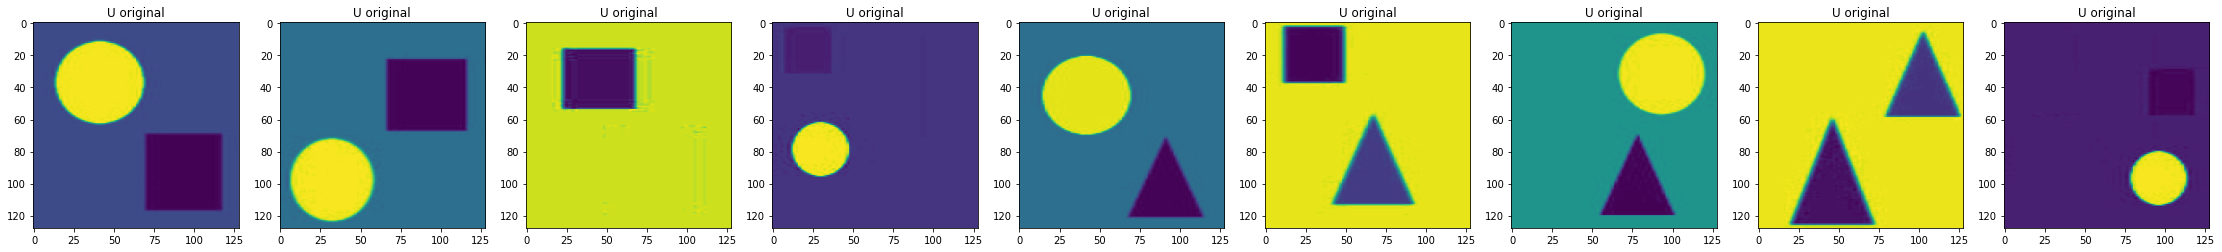

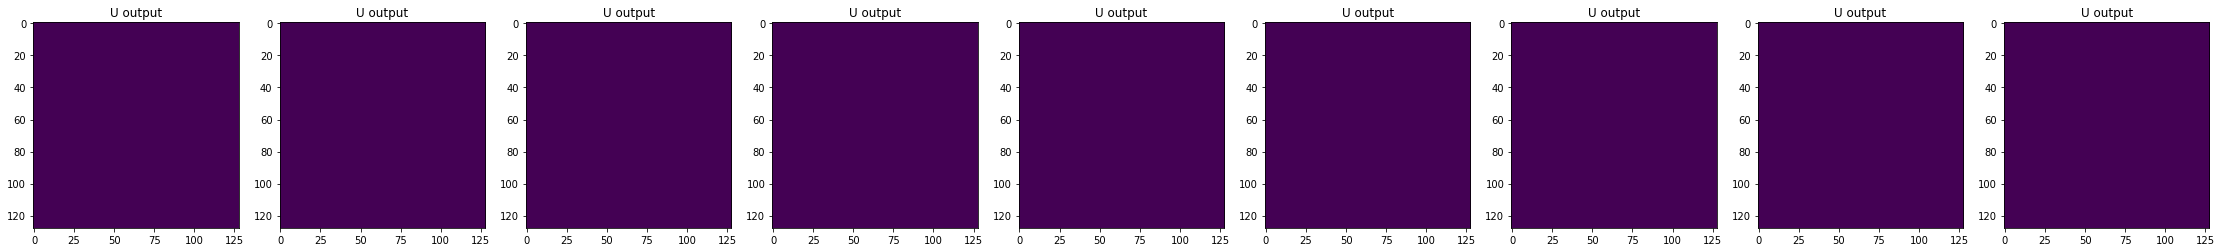

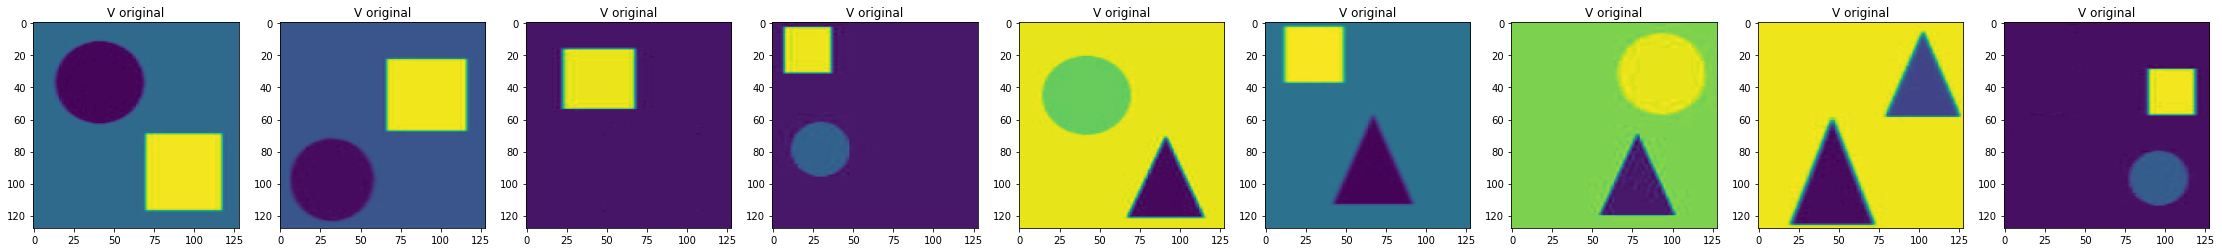

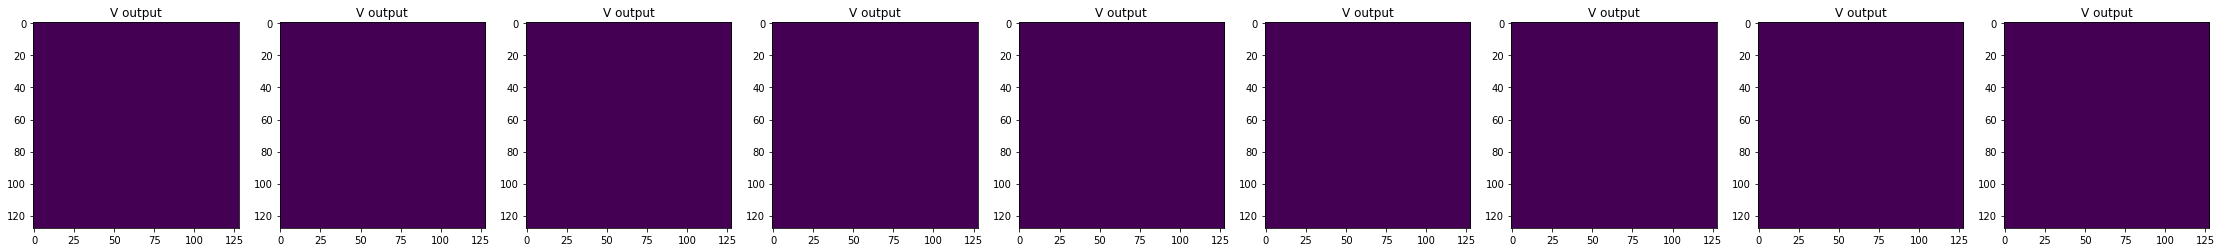

In [30]:
print(dcnn.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = dcnn.predict(test_y)
result = np.zeros((test_yuv.shape[0], train_y.shape[1], train_y.shape[2], 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])